In [1]:
from pathlib import Path
import pandas as pd

In [2]:
base_dir = Path().cwd().parent
processed_dir = base_dir/'data'/'processed'/'daily_report'

days = pd.date_range('01/22/2020', '04/15/2020', normalize=True)
days = days.strftime('%m-%d-%Y')

In [3]:
def generate_dataframe():
    
    df = pd.DataFrame()  

    for day in days:
        temp = pd.read_csv(processed_dir/f'{day}.csv')
        temp.loc[:, 'date'] = pd.to_datetime(day)
        df = df.append(temp)
        
    return df

df = generate_dataframe()

In [4]:
df_ger = df[df['country'] == 'Germany']
df_ger = df_ger.set_index('date')

In [5]:
column_list = ['confirmed', 'recovered', 'active']

df_ger['active'] = df_ger['confirmed'] - df_ger['recovered'] - df_ger['deaths']  

In [6]:
for c in column_list:
    shift_col = df_ger[c].shift(1).squeeze()
    df_ger.loc[:, f'{c}_delta'] = df_ger[c] - shift_col

In [7]:
df_roll = df_ger['confirmed_delta'].rolling(window=3, center=True).mean()
df_roll = df_roll.round()

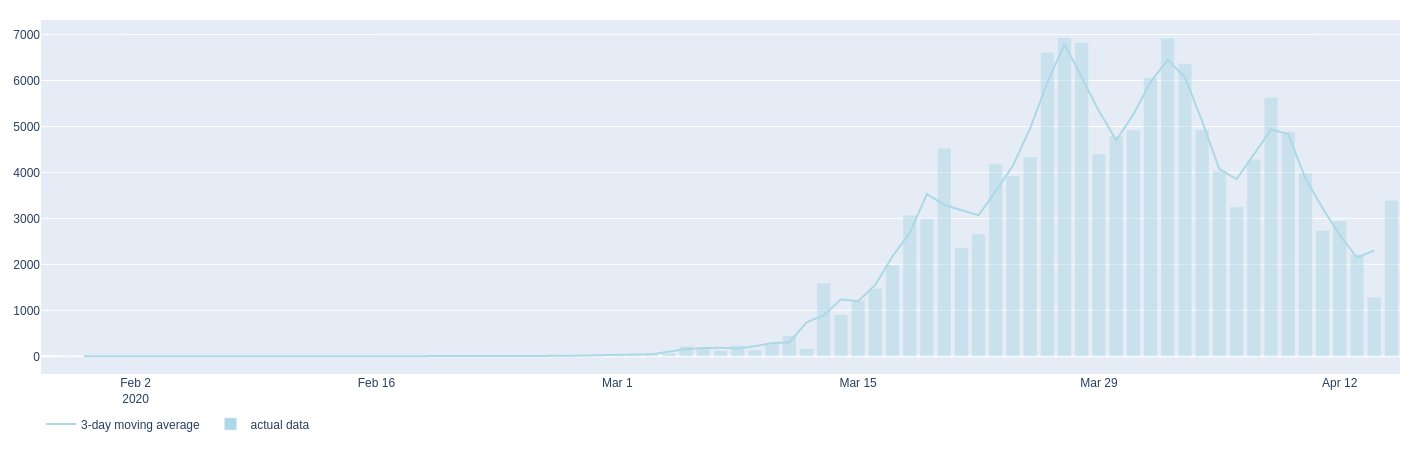

In [27]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure()

fig.add_trace(go.Scatter(
    name='3-day moving average',
    x=df_roll.index, 
    y=df_roll, 
    marker_color='lightblue',
    hoverinfo='skip'
))

fig.add_trace(go.Bar(
    name='actual data',
    x=df_ger.index, 
    y=df_ger['confirmed_delta'], 
    hoverinfo='y',
    marker=dict(
        color='lightblue',
        opacity=0.5,
    )
))
    

fig.update_layout(
    dict(
        width=800,
        height=450,
        legend_orientation='h',
        paper_bgcolor='rgba(255,255,255,1)',
        margin=dict(t=20,l=20,r=20,b=20)
    )
)

fig.show()